In [1]:
## Parameters
fold=1
dataset="kr-vs-kp"
d = 2# depth

## Create Cython Modules

In [2]:
#!python setup.py build_ext --inplace

In [3]:
from Pricing_Branching import PP_node, get_misclassification, get_split_values,get_misclassification_bag

## Imports

In [4]:
## imports
import json
import logging
import pandas as pd
# Define this directive to disable the deprecated NumPy API
#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
import numpy as np
import copy
from gurobipy import *
import time
from copy import deepcopy
from sklearn import preprocessing as pre
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import concurrent.futures



In [5]:
def print_iteration_separator():
    separator_length = 50
    separator_char = '*'

    separator_line = separator_char * separator_length
    print(separator_line)

In [6]:
def get_shuffle_indices(n):
    arr=np.arange(0,n)
    np.random.shuffle(arr)
    return arr

def split_into_batches(data_x,data_y, n):
    global indices
    global batch_sizes
    batch_size = len(data) // n
    remainder = len(data) % n

    start_idx = 0
    batch_sizes=[]
    for i in range(n):
        batch_end = start_idx + batch_size + (1 if i < remainder else 0)
        batch_sizes.append(batch_end-start_idx)
        yield data_x[indices[start_idx:batch_end]],data_y[indices[start_idx:batch_end]]
        start_idx = batch_end

indices=get_shuffle_indices(2000)

## Read Data

In [7]:

relpath="./Datasets/"+dataset+"/fold="+str(fold)+"_train.csv"
data = pd.read_csv(relpath)#pd.read_csv("./Datasets/fold=1_train.csv")


X = data.iloc[:,1:]
y = data.iloc[:,:1]



P = [i for i in range(data.shape[1]-1)]
K = list(data.y.unique())
k=len(K)

min_bucket_leaf= 0 # minimum number of data that should fall under each leaf
D = list(range(d))
N = list(range(X.shape[0]))
n = len(N)
n_leaves = 2**d
p = X.shape[1]

y_k = np.zeros((X.shape[0], len(K)))
for k in range(len(K)):
    y_k[np.where(y==K[k])[0],k] = 1

y_k=y_k.astype(np.int32)
x = np.array(X,dtype=np.int32)
y_arr=np.array(y,dtype=np.int32).flatten()-1

## Parameter Generators

In [8]:

#### transfer these to cython!    
def get_alpha(pattern, j, level, split_values=None):
    try:
        if pattern[level] == j and split_values[level] == 1:
            out = 1
        else:
            out = 0
    except:
        print("Incorrect pattern")
        print([pattern, j, level, split_values])
        out = 0

    return out

def get_beta(pattern, j, level, split_values):
    try:
        if pattern[level] == j and split_values[level] == 0:
            out = 1
        else:
            out = 0
    except:
        print([pattern, j, level, split_values])
        print("Incorrect pattern")
        out = 0

    return out


#### transfer these to cython!    
def get_alpha_beta(pattern, j, feature_split_condition):
    """
    This function assumes that the pattern provided is a tuple of lists, with 0-split features being the second entry,
    and 1-split features being the first entry. If the feature split condition matches the position of the feature,
    the function returns one. 
    """
    try:
        if j in pattern[1-feature_split_condition]:
            out = pattern[1-feature_split_condition].count(j)
        else:
            out = 0
    except:
        print("Incorrect pattern")
        print([pattern, j, feature_split_condition])
        out = 0

    return out





## return the solution of the tree:
### WRITE CODE HERE###
## column generator function
def get_column(leaf,d,pattern,p):
    """ 
    Gives the column associated with a certain pattern. The column vector will have length 2^d + (2^(d+1))*p
    Establishes the leaf's connection with all cousins, by order of closeness of cousin degrees.
    The connections at one level are formed for each cousin pair by iterating each feature. This procedure is continued for each level in which the
    pair continues to be associated with each other.

    """

    my_column=np.zeros(2**d)
    my_column[leaf]=1
    
    cons_list=[my_column]
    start=leaf*2*p
    leaf_cons=np.zeros(2**(d+1)*p)
    for feature in range(p):
        for split_condition in range(2): # binary split tree
            leaf_cons[start+2*feature+split_condition]=-1*get_alpha_beta(pattern,feature,1-split_condition)
    cons_list.append(leaf_cons)
    column=np.concatenate(cons_list)

    return(column.reshape(len(column),1)) # appropriate column shape

def get_w_columns(d,p):
    """
    Takes tree depth and number of features p to return the w columns always present in the model.
    The returned array can be joined horizontally with the pattern constraints.
    Cython version exists, but is not in use.
s
    """
    number_of_nodes= 2**(d)-1
    len_w = number_of_nodes*p
    len_cons=p*2**(d+1) ## binary splits
    assignment_cons=np.zeros((2**d,len_w))
    all_cons=[assignment_cons]
    

    for leaf in range(2**d):
        

        split_values=1-get_split_values(leaf,d).astype(int)
        w_indices_for_leaf=[0]

        ### obtain the leaf's association with split nodes
        for d_temp in range(1,d):
            values=np.arange(2**d_temp -1,2**d_temp -1 + 2**d_temp)
            w_index=leaf//(2**(d-d_temp))
            w_indices_for_leaf.append(values[w_index])


        ### build the constraint set:
        for feature_ in range(p):
            feature_cons=[]
            for node in range(number_of_nodes):
                cons_temp=np.zeros((2,p))
                if node in w_indices_for_leaf:
                        index=w_indices_for_leaf.index(node)
                        cons_temp[split_values[index],feature_]=1
                feature_cons.append(cons_temp)

            cons_leaf_feature=np.hstack(feature_cons)
            all_cons.append(cons_leaf_feature)
            

    all_cons=np.vstack(all_cons)
    
    return all_cons   
        
        
def get_w_indices(leaf):
    """
    Cython version exists, but is not in use.
    """
    # returns effected indices of each leaf
    w_indices_for_leaf=[0]
    ### obtain the leaf's association with split nodes
    for d_temp in range(1,d):
        values=np.arange(2**d_temp -1,2**d_temp -1 + 2**d_temp)
        w_index=leaf//(2**(d-d_temp))
        w_indices_for_leaf.append(values[w_index])

    return w_indices_for_leaf

def get_affected_leaves(node,w_indices_for_leaves):
    """
    Cython version exists, but is not in use.
    """
    affected_leaves=[]
    ### obtain the leaf's association with split nodes

    for leaf in range(len(w_indices_for_leaves)):
        values=w_indices_for_leaves[leaf]
        if node in values:
            affected_leaves.append(leaf) 

    return affected_leaves

def get_cousins(depth, leaf):
    """
    returns a list of cousins ordered by their degree
    """
    cousins=[[] for level in range(depth)]
    cousins[depth-1]=[i for i in range(2**depth) if i!=leaf]
    for i in range(depth-1,0,-1):
        middle_split= leaf//2**(i)
        cousins[i-1]=cousins[i][-(2**(i)-1):] if middle_split else cousins[i][:2**(i)-1] 


    return cousins



def calculate_miss(x_tilde,y_tilde,j,RHS):
    indices= x_tilde[:,j]==RHS
    x_tilde_2= x_tilde[indices,:]
    y_tilde_2= y_tilde[indices,:]
    n_j= len(x_tilde_2)
    count=np.sum(y_tilde_2,axis=0)
    return n_j-np.max(count)

def calculate_gini(x_tilde,y_tilde,j,RHS):
    indices= x_tilde[:,j]==RHS
    x_tilde_2= x_tilde[indices,:]
    y_tilde_2= y_tilde[indices,:]
    n_j= len(x_tilde_2) # number of data points
    count=np.sum(y_tilde_2,axis=0) #number of ones and zeros
    gini= 1-np.sum(np.square((count/n_j))) #1- sum(p^2) -- sum over classes
    return gini

from more_itertools import distinct_permutations
from itertools import product,combinations,combinations_with_replacement



def find_all_bags(feature_num,leaf,d):
    """
    takes number of features and returns all possible bag combinations
    includes repeats
    """
    split_values=get_split_values(leaf,d)
    max_num=int(np.sum(split_values))
    input_list=np.arange(feature_num)
    input_set = set(input_list)
    result_tuples = []

    
    for i in combinations_with_replacement(input_list, max_num):
        list1 = list(i) # 1 features
        set_temp1=set(list1)
        set2= input_list#list(input_set-set(i)) # 0 features  #### either enable or disable selecting a feature as both 0 and 1 # input_set
        for j in combinations_with_replacement(set2, d-max_num):
            list2 = list(j)  # 0 features
            set_temp2=set(list2)
            
            result_tuples.append((list1, list2))
    
    return result_tuples

def find_all_bags_fixed_feature(feature_num,leaf,d,fixed_feature_info):
    """
    takes number of features and returns all possible bag combinations
    includes repeats
    uses the fixed feature (given in a list of tuples)
    """
    # we have to not use the features above!
    
    split_values=get_split_values(leaf,d)
    #dont_use=set(fixed_feature_info[fixed_feature_info[:,-1]==0][:,1].tolist()) # get non-used features for splits
    fixed_all=fixed_feature_info[fixed_feature_info[:,-1]==1].tolist() # get the fixed features

    input_list=np.arange(feature_num)
    input_set = set(input_list)#s-dont_use
    
    result_tuples = []
    
    for condition in set(get_split_values(leaf,d).astype(int)):

        fixed_pattern_template=([],[])
        counters=[0,0]
    

        for fixed in fixed_all:
            feature=fixed[0]
            #w_index=fixed[0]
            #depth_affected=w_indices.index(w_index)
            #condition= get_split_values(leaf,d).astype(int)[depth_affected]
            fixed_pattern_template[1-condition].append(feature)
            counters[1-condition]+=1
            max_num=int(np.sum(split_values))-counters[0]

            # for every possible split use case!
            for i in combinations_with_replacement(input_set, max_num):
                list1 = list(i) # 1 features
                set_temp1=set(list1)
                set2= input_set#list(input_set-set(i)) # 0 features  #### either enable or disable selecting a feature as both 0 and 1 # input_set
                for j in combinations_with_replacement(set2, d-max_num-sum(counters)):
                    list2 = list(j)  # 0 features
                    set_temp2=set(list2)
                    result_tuples.append((list1+fixed_pattern_template[0], list2+fixed_pattern_template[1])) # add the fixed feature
    
    return result_tuples

def find_all_repeating_bags(feature_num,leaf,d):
    """
    takes number of features and returns all possible bag combinations
    includes repeats
    """
    split_values=get_split_values(leaf,d)
    max_num=int(np.sum(split_values))
    input_list=np.arange(feature_num)
    input_set = set(input_list)
    result_tuples = []

    
    for i in combinations_with_replacement(input_list, max_num):
        list1 = list(i) # 1 features
        set2 = input_set #list(input_set-set(i)) # 0 features
        set_temp1=set(list1)
    
            

        for j in combinations_with_replacement(set2, d-max_num):
            list2 = list(j)  # 0 features
            set_temp2=set(list2)

            if (len(set_temp1)!=len(list1) or len(set_temp2)!=len(list2)) or len(set_temp1.intersection(set_temp2)) >0: #and len(set_temp1.intersection(set_temp2)) ==0: ### for prohibiting invalid patterns #
                ## repeating check and valid check
                result_tuples.append((list1, list2))



    
    return result_tuples

#Cythonized version exists
"""
def get_miss_bag(pattern_bag,leaf,x,y_k):
    # pattern_bag includes a tuple of lists
    global d
    splits=1-get_split_values(leaf,d).astype(int)

    pattern=[] #[0] 

    counter=np.zeros(2,dtype=np.int32)
    #[[0, 0], []]
    for split_condition in splits:
        try:
            pattern.append(pattern_bag[split_condition][counter[split_condition]])
            counter[split_condition]+=1
        except: # a feature is repeated for branching
            pattern.append(pattern_bag[split_condition][counter[split_condition]-1])
        
  
    return get_misclassification(x, y_k, np.array(pattern,dtype=np.int32), leaf)
"""
# Define a custom sorting key
def custom_sort(item):
    return (len(item[0]), len(item[1]))


def get_shuffle_indices(n):
    arr=np.arange(0,n)
    np.random.shuffle(arr)
    return arr

def split_into_batches(data_x,data_y, n):
    global indices
    global batch_sizes
    batch_size = len(data) // n
    remainder = len(data) % n

    start_idx = 0
    batch_sizes=[]
    for i in range(n):
        batch_end = start_idx + batch_size + (1 if i < remainder else 0)
        batch_sizes.append(batch_end-start_idx)
        yield data_x[indices[start_idx:batch_end]],data_y[indices[start_idx:batch_end]]
        start_idx = batch_end
        

list of all patterns that are valid

In [9]:
#### generate all tuples and randomly add to the initial set
###### NEW PATTERN DEFINITION ####
np.random.seed(42)# set seed (also restart seed!)

### add one level splits!
#### store the set of all patterns
# Sort the couples list using the custom key
all_patterns_list=[find_all_bags(p,leaf,d) for leaf in range(2**d)]
all_patterns_list_sorted=[sorted(all_patterns_list[leaf], key=custom_sort) for leaf in range(2**d)]
all_repeating_patterns_list=[find_all_repeating_bags(p,leaf,d) for leaf in range(2**d)] # ensure repeats



In [10]:

num_patterns_all=np.sum([len(all_patterns_list[i]) for i in range(2**d)])

In [11]:
print('Number of all valid patterns:',num_patterns_all)

Number of all valid patterns: 4370


In [12]:
### instance log
#relpath="./Datasets/"+dataset+"/fold="+str(fold)
#filename=relpath+'_instance_log_'+str(d)+'.txt'
#with open(filename, 'w') as file:
#    K = list(data.y.unique())
#    texts=[str(n),str(p),str(num_patterns_all),str(num_patterns_initial),str(len(K))]
#    separator = ","
#    data = separator.join(texts)
#    file.write(data)

All Patterns

## Master Problem, LP Relaxation

In [13]:
def solve_partial_OCT_IP_matrix(pattern_list, x, y_k, d,p):
    global n
    global fold
    global dataset

    ### Baseline model
    ## the W variables coefficients will be filled before column generation
    cons_basis= get_w_columns(d,p)
    
    
    ### get A matrix ###
    columns = [cons_basis]
    _ = [
        [columns.append(get_column(leaf,d, pattern, p)) for leaf in range(len(pattern_list)) for pattern in pattern_list[leaf]]    
    ] # null list to hide extend output

    miss_and_count=[[get_misclassification_bag(x, y_k, pattern_bag, leaf) for pattern_bag in pattern_list[leaf]]for leaf in np.arange(len(pattern_list),dtype=np.int32)] 
    
    ### MISSS function change here
    
    A= np.concatenate(columns,axis=1)
    
    
    ### Add the tightening constraints
    pattern_list_constraints=np.concatenate([np.array(miss_and_count[leaf][pattern][2],dtype=np.float64).reshape(n,1) for leaf in range(len(pattern_list)) for pattern in range(len(pattern_list[leaf]))],axis=1) # adds cuts
    cuts_W=np.zeros(shape=(len(pattern_list_constraints),(2**d-1)*p)) # w - columns for cuts
    pattern_list_constraints_with_W= np.hstack([cuts_W,pattern_list_constraints])# concat the two horizontally
    A=np.concatenate([A,pattern_list_constraints_with_W],axis=0) # A matrix with tightened cuts
    
    ### get b ###
    b = np.concatenate([np.ones(len(pattern_list)),np.zeros(len(A)-len(pattern_list)-len(pattern_list_constraints)),np.ones(len(pattern_list_constraints))]) # RHS for cuts
    #b = np.concatenate([np.ones(len(pattern_list)),np.zeros(len(A)-len(pattern_list))]) # RHS
    ### get c ###

    c=np.array([miss_and_count[leaf][pattern][0]/n for leaf in range(len(pattern_list)) for pattern in range(len(pattern_list[leaf]))])
    c=np.concatenate([np.zeros(cons_basis.shape[1]),c]) ### add 0 obj for w
    
    ### build model ###

    mp = Model('MasterProblemLP')
    #mp.setParam('OutputFlag', 0)
    mp.setParam('TimeLimit', 3600)
    
    # add as many variables as the number of patterns
    mp.addMVar((2**d-1)*p, vtype=GRB.BINARY,name='w') 
    mp.addMVar(A.shape[1]-(2**d-1)*p, vtype=GRB.BINARY,name='pattern') 

    mp.addMConstr(A, None, '=' , b)

    #sp.setMObjective(None,c_new,0,None,None,None,GRB.MAXIMIZE)
    mp.setMObjective(None, c, 0.0, xQ_L=None, xQ_R=None, xc=None, sense=GRB.MINIMIZE )
    mp.update()
    # CART solution
    vars=mp.getVars()
    for l in range(2**d):
        vars[(2**d-1)*p+np.sum([len(pattern_list[leaf]) for leaf in range(l+1)])-1].start=1 # last patterns are cart
        mp.update()

    relpath="./Datasets/"+dataset+"/fold="+str(fold)
    filename=relpath+'_IP_log_'+str(d)+'.txt'
    timer_start=time.time()
    #with open(filename, 'w') as file:
    #    while mp.status!=2 and time.time()- timer_start < 3600: # while not optimal and overall time limit not reached
    #        mp.setParam('TimeLimit', 100) # write solution every 100 seconds
    #        mp.optimize()
    #        texts = [str(mp.objval),str(mp.objbound),str(time.time()- timer_start)] #we do not write the solution, we log: objval, bound, time, # of columns
    #        separator = ","
    #        data = separator.join(texts)
    #        file.write(data+ '\n')
    mp.optimize()
    timer_end=time.time()
    return mp, A, b, c,timer_end-timer_start

def solve_partial_OCT_matrix(pattern_list, x, y_k, d,p):
    global n
    
    ### Baseline model
    ## the W variables coefficients will be filled before column generation
    cons_basis= get_w_columns(d,p)
    
    
    ### get A matrix ###
    columns = [cons_basis]
    _ = [
        [columns.append(get_column(leaf,d, pattern, p)) for leaf in range(len(pattern_list)) for pattern in pattern_list[leaf]]    
    ] # null list to hide extend output

    miss_and_count=[get_misclassification_bag(x, y_k, pattern_bag, leaf) for leaf in np.arange(len(pattern_list),dtype=np.int32) for pattern_bag in pattern_list[leaf]]
    
    ### MISSS function change here
    
    A= np.concatenate(columns,axis=1)


    ### get b ###
    b = np.concatenate([np.ones(len(pattern_list)),np.zeros(len(A)-len(pattern_list))]) # RHS
    
    ### get c ###

    c=np.array([miss_and_count[i][0]/n for i in range(len(miss_and_count))])
    c=np.concatenate([np.zeros(cons_basis.shape[1]),c]) ### add 0 obj for w
    
    ### build model ###

    mp = Model('MasterProblemLP')
    mp.setParam('OutputFlag', 0)
    
    # add as many variables as the number of patterns
    mp.addMVar(A.shape[1]-len(miss_and_count), vtype=GRB.CONTINUOUS,name='w',lb=0) 
    mp.addMVar(len(miss_and_count), vtype=GRB.CONTINUOUS,name='pattern',lb=0) 

    mp.addMConstr(A, None, '=' , b)

    #sp.setMObjective(None,c_new,0,None,None,None,GRB.MAXIMIZE)
    mp.setMObjective(None, c, 0.0, xQ_L=None, xQ_R=None, xc=None, sense=GRB.MINIMIZE )
    mp.optimize()

    return mp, A, b, c




def dual_partial_OCT_matrix(A,b,c):
    ### build model ###
    dual_mp=Model('Dual')

    dual_mp.setParam('OutputFlag', 0)
    
    # add as many variables as the number of constraints
    dual_mp.addMVar(A.shape[0], vtype=GRB.CONTINUOUS,ub=GRB.INFINITY,lb=-GRB.INFINITY,name='pattern') 

    dual_mp.addMConstr(A.T, None, '<' , c)

    #sp.setMObjective(None,c_new,0,None,None,None,GRB.MAXIMIZE)
    dual_mp.setMObjective(None, b, 0.0, xQ_L=None, xQ_R=None, xc=None, sense=GRB.MAXIMIZE )
    dual_mp.optimize()

    return dual_mp




In [14]:
#m,A,b,c=solve_partial_OCT_matrix(all_patterns_list, x, y_k, d,p)

In [15]:
#m.objval

In [16]:
#m,A,b,c,_=solve_partial_OCT_IP_matrix(all_patterns_list, x, y_k, d,p)

In [17]:
#m.ObjVal

In [18]:
#m.Runtime

In [19]:
def printIPVars(IP_model):
    # Print non-zero decision variables, HERE BOTH PATTERN NUMBER AND LEAF NUMBER STARTS FROM 0
    pattern_counter=[0,]*(2**(d))
    leaf_pointer_array=IP_model.getA()[:2**(d)].toarray()
    for i, var in enumerate(IP_model.X):
            leaf=np.where((leaf_pointer_array[:,i]==1))[0][0]    
            if var > 0:
                index= pattern_counter[leaf]
                print(f'Leaf {leaf+1} pattern {index+ 1}: {var}')
                print('pattern:',all_patterns_list[leaf][index])
            pattern_counter[leaf]+=1 #update index

In [20]:
#list_unraveled=[]
#_=[list_unraveled.extend(all_patterns_list[l]) for l in range(2**d)]
#indices=np.where(np.array(m.X)[(2**d-1)*p:])[0]
#for i in indices:
#    print(list_unraveled[i])

## CART 

In [21]:
# Function to recursively extract split features
def extract_split_features(d,tree_structure,leaf):
    """
    Node: 0,1,2,...2**d-1
    """
    empty_pattern=tuple([[] for _ in range(2)])
    nodes=get_w_indices(2**d-leaf-1) # we are doing this because CART builder assumes right splits are postive and left are negative
    splits=get_split_values(leaf,d).astype(int)
    tree_features=tree_structure.feature[tree_structure.feature>=0]
    for node in nodes:
        feature_new = tree_features[node] if node<len(tree_features) else -1
        level=0#(node+1)//(2**(d-1))
        flag=node in np.arange(2**level-1,2**(level+1)-1).tolist()
        while not flag:
            level+=1
            flag=node in np.arange(2**level-1,2**(level+1)-1).tolist()
            
        empty_pattern[1-splits[level]].append(feature_new) if feature_new >=0 else empty_pattern[1-splits[level]].append(feature_old)
        feature_old=feature_new # store this split
    
    return empty_pattern


In [22]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
clf = tree.DecisionTreeClassifier(max_depth=d)
clf = clf.fit(x, y)
prediction = clf.predict(x)
cart_acc=1-accuracy_score(y,prediction)
print('CART Miss:',cart_acc)

CART Miss: 0.22114047287899863


CART Result


[Text(0.6, 0.8333333333333334, 'x[19] <= 0.5\ngini = 0.499\nsamples = 2876\nvalue = [1502, 1374]'),
 Text(0.4, 0.5, 'x[31] <= 0.5\ngini = 0.486\nsamples = 2357\nvalue = [983, 1374]'),
 Text(0.5, 0.6666666666666667, 'True  '),
 Text(0.2, 0.16666666666666666, 'gini = 0.475\nsamples = 1541\nvalue = [944.0, 597.0]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.091\nsamples = 816\nvalue = [39, 777]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 519\nvalue = [519, 0]'),
 Text(0.7, 0.6666666666666667, '  False')]

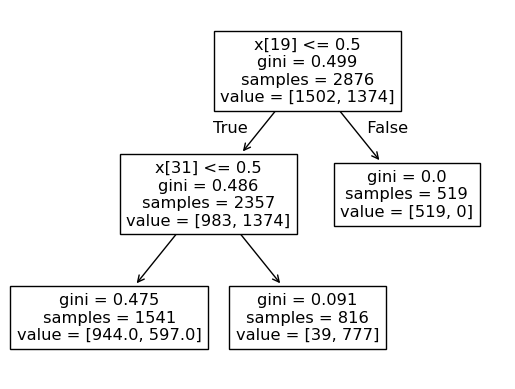

In [23]:
print('CART Result')
tree.plot_tree(clf)

In [24]:
## store incumbent CART patterns
inc_patterns_CART=[[extract_split_features(d,clf.tree_,leaf)] for leaf in range(2**d)]

In [25]:
## add cart patterns to assoc. pattern list
_=[all_patterns_list[l].append(inc_patterns_CART[l][0]) for l in range(2**d)]

In [26]:
from itertools import combinations_with_replacement

## Parameters

Solve the IP model!

In [27]:
print('Solving IP Model')
IP_model=solve_partial_OCT_IP_matrix(all_patterns_list, x, y_k, d,p)

Solving IP Model
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 3184 rows, 4488 columns and 2906798 nonzeros
Model fingerprint: 0xb2404bb9
Variable types: 0 continuous, 4488 integer (4488 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e-04, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start produced solution with objective 0.22114 (0.29s)
Loaded user MIP start with objective 0.22114

Presolve removed 76 rows and 4 columns (presolve time = 5s) ...
Presolve removed 76 rows and 4 columns (presolve time = 10s) ...
Presolve removed 76 rows and 4 columns (presolve time = 15s) ...
Presolve removed 76 rows and 4 columns (preso

In [28]:
def printIPVars(IP_model):
    # Print non-zero decision variables, HERE BOTH PATTERN NUMBER AND LEAF NUMBER STARTS FROM 0
    inc_patterns=[[] for leaf in range(2**d)]
    pattern_counter=[0,]*(2**(d))
    leaf_pointer_array=IP_model[0].getA()[:2**(d)].toarray()
    for i, var in enumerate(IP_model[0].X[(2**d-1)*p:]):
            leaf=np.where((leaf_pointer_array[:,(2**d-1)*p+i]==1))[0][0]    
            if var > 0:
                index= pattern_counter[leaf]
                print(f'Leaf {leaf+1} pattern {index+ 1}: {var}')
                print('pattern:',all_patterns_list[leaf][index])
                inc_patterns[leaf].append(all_patterns_list[leaf][index])
            pattern_counter[leaf]+=1 #update index
    return inc_patterns

In [29]:
inc_patterns_IP=printIPVars(IP_model)

Leaf 1 pattern 564: 1.0
pattern: ([19, 31], [])
Leaf 2 pattern 1198: 1.0
pattern: ([31], [19])
Leaf 3 pattern 374: 1.0
pattern: ([9], [31])
Leaf 4 pattern 329: 1.0
pattern: ([], [9, 31])


In [30]:
print('IP Model Objective:', IP_model[0].objval)
print('IP Model Optimization Time:',IP_model[-1])

IP Model Objective: 0.12447844228094576
IP Model Optimization Time: 22.11396026611328


## Display Results

In [31]:
def printIncumbentVars(inc_node):
    print('Incumbent Node Solution is:')
    inc_patterns=[[] for leaf in range(2**d)]
    # Print non-zero decision variables, HERE BOTH PATTERN NUMBER AND LEAF NUMBER STARTS FROM 0
    pattern_counter= [0,]*(2**(d))
    leaf_pointer_array=inc_node.mp.getA()[:2**(d)].toarray() 
    try:
        
        for i, var in enumerate(inc_node.IP.X[(2**d-1)*p:]):
                leaf=np.where((leaf_pointer_array[:,(2**d-1)*p+i]==1))[0][0]   
                if var > 0:
                    index= pattern_counter[leaf]
                    print(f'Leaf {leaf+1} pattern {index+ 1}: {var}' if not aggregate else f'Fork {leaf+1} pattern {index+ 1}: {var}')
                    print('pattern:',inc_node.pattern_list[leaf][index])
                    inc_patterns[leaf].append(inc_node.pattern_list[leaf][index])
                pattern_counter[leaf]+=1 #update index
    except:
        
        for i, var in enumerate(inc_node.mp.X[(2**d-1)*p:]):
                leaf=np.where((leaf_pointer_array[:,(2**d-1)*p+i]==1))[0][0]
                if var > 0:
                    index= pattern_counter[leaf]
                    print(f'Leaf {leaf+1} pattern {index+ 1}: {var}' if not aggregate else f'Fork {leaf+1} pattern {index+ 1}: {var}')
                    print('pattern:',inc_node.pattern_list[leaf][index])
                    inc_patterns[leaf].append(inc_node.pattern_list[leaf][index])
                pattern_counter[leaf]+=1 #update index
    return inc_patterns

def printCART(inc_patterns_CART):
    print('Initial CART solution')
    for leaf in range(len(inc_patterns_CART)):
            print(f'Leaf {leaf+1}')
            print('pattern:',inc_patterns_CART[leaf][0])
    return inc_patterns_CART #indicates CART solution will be used

Root node analysis

# Test Dataset

In [32]:
relpath="./Datasets/"+dataset+"/fold="+str(fold)+"_test.csv"
data = pd.read_csv(relpath)#pd.read_csv("./Datasets/fold=1_train.csv")

X = data.iloc[:,1:]
y = data.iloc[:,:1]

y_k = np.zeros((X.shape[0], len(K)))
for k in range(len(K)):
    y_k[np.where(y==K[k])[0],k] = 1

y_k=y_k.astype(np.int32)
x = np.array(X,dtype=np.int32)

In [33]:
def get_tree_mis(inc_patterns,d,x,y_k):
    miss=0
    for leaf in range(2**d):
        miss+=get_misclassification_bag(x, y_k, inc_patterns[leaf][0], leaf)[0]
    return miss/len(x)

In [34]:

miss_IP=get_tree_mis(inc_patterns_IP,d,x,y_k)

In [35]:

print('IP Test Accuracy Score is:', 1-miss_IP)

IP Test Accuracy Score is: 0.8125


In [36]:
#Training Accuracy
#Test Accuracy
#Time
#Opt Gap

In [37]:
print('IP Model Objective:', IP_model[0].objval)
print('IP Model Optimization Time:',IP_model[-1])

IP Model Objective: 0.12447844228094576
IP Model Optimization Time: 22.11396026611328


In [38]:

res_MIP=np.array([1-IP_model[0].objval,1-miss_IP,IP_model[-1],IP_model[0].MIPGap])

labels=np.array(['Training Accuracy','Test Accuracy','Time','Opt Gap'])

In [39]:
res_final=np.vstack([labels,res_MIP]).T

In [40]:
res_final

array([['Training Accuracy', '0.8755215577190543'],
       ['Test Accuracy', '0.8125'],
       ['Time', '22.11396026611328'],
       ['Opt Gap', '0.0']], dtype='<U32')

In [41]:
import pickle

In [42]:
# save results
relpath="./Datasets/"+dataset+"/fold="+str(fold)
np.savetxt(relpath+'_res_IP_WCuts'+str(d)+'.txt',res_final,fmt='%s')

In [43]:
### read using
# Read dictionary pkl file
#
#with open(file_name, 'rb') as fp:
#    CG_Counters = pickle.load(fp)


In [44]:
import sys

orig_stdout = sys.stdout
f = open(relpath+'_DecisionRules_IPWCuts_'+str(d)+'.txt', 'w')
sys.stdout = f

print(inc_patterns_IP)

sys.stdout = orig_stdout
f.close()